<a href="https://colab.research.google.com/github/amarabuco/seriestemporais/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U statsmodels

# Imports

In [3]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [6]:
mpl.rcParams['figure.figsize'] = [20, 5]

In [7]:
from datetime import datetime
custom_time_parser = lambda x: datetime.strptime(x, "%H:%M:%S.%f").time() if '.' in x else datetime.strptime(x, "%H:%M:%S").time()

In [8]:
custom_time_parser('01:02:03.200000')

datetime.time(1, 2, 3, 200000)

In [9]:
custom_time_parser('01:02:04')

datetime.time(1, 2, 4)

In [10]:
train_orig = pd.read_csv('../dataset/case_28_subsampled_200ms_train.csv', parse_dates=['Time'], date_parser=custom_time_parser)
test = pd.read_csv('../dataset/case_28_subsampled_200ms_test.csv', parse_dates=['Time'], date_parser=custom_time_parser)
train_orig

,Time,EEG,BIS
0,00:00:00,NaN,NaN
1,00:00:00.200000,NaN,NaN
2,00:00:00.400000,NaN,NaN
3,00:00:00.600000,NaN,NaN
4,00:00:00.800000,NaN,NaN
...,...,...,...
16724,00:55:44.800000,0.01526,80.0
16725,00:55:45,0.01526,80.0
16726,00:55:45.200000,0.01526,80.0
16727,00:55:45.400000,5.99817,80.0


In [11]:
train_orig.index = train_orig['Time']
train_orig.drop(columns=['Time'], inplace=True)
test.index = test['Time']
test.drop(columns=['Time'], inplace=True)
train_orig

,EEG,BIS
Time,,
00:00:00,NaN,NaN
00:00:00.200000,NaN,NaN
00:00:00.400000,NaN,NaN
00:00:00.600000,NaN,NaN
00:00:00.800000,NaN,NaN
...,...,...
00:55:44.800000,0.01526,80.0
00:55:45,0.01526,80.0
00:55:45.200000,0.01526,80.0


## Validation Split (25%) = 1/3 of 75% of train set (the last 1/3)

In [12]:
25/(100*0.75)

0.3333333333333333

In [13]:
100*0.75*1/3

25.0

In [14]:
train = train_orig.iloc[:int(len(train_orig) * 2/3)]['EEG']
val = train_orig.iloc[int(len(train_orig) * 2/3):]['EEG']
test = test['EEG']

print(train.shape)
print(val.shape)

(11152,)
(5577,)


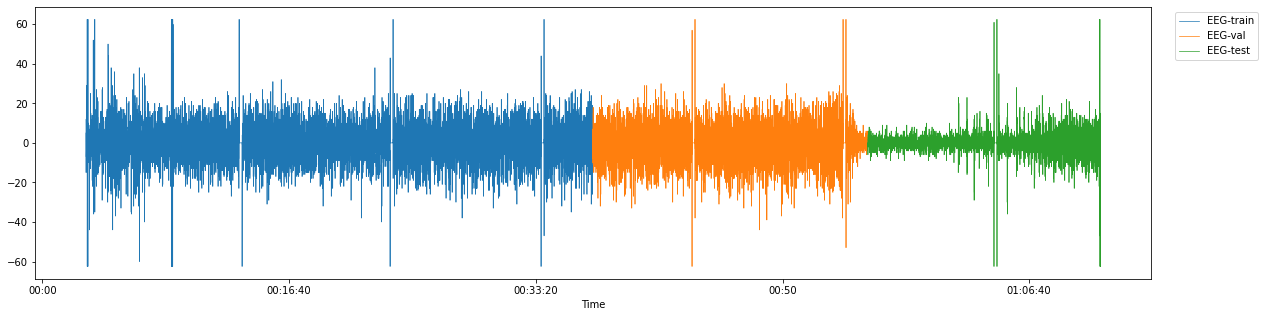

In [15]:
linewidth = 0.7
ax = train.rename(f'{train.name}-train').plot(linewidth = linewidth)
ax = val.rename(f'{train.name}-val').plot(ax=ax, linewidth = linewidth)
test.rename(f'{test.name}-test').plot(ax=ax, linewidth = linewidth)
plt.legend(bbox_to_anchor=(1.1, 1), loc="upper right")

In [16]:
print(f'Train: {len(train.index)}')
print(f'Val: {len(val.index)}')
print(f'Test: {len(test.index)}')
total = len(train.index) + len(val.index) + len(test.index)
print(f'\nTrain: {len(train.index)/total*100:.3f}%')
print(f'Val: {len(val.index)/total*100:.3f}%')
print(f'Test: {len(test.index)/total*100:.3f}%')

Train: 11152
Val: 5577
Test: 5577

Train: 49.996%
Val: 25.002%
Test: 25.002%


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


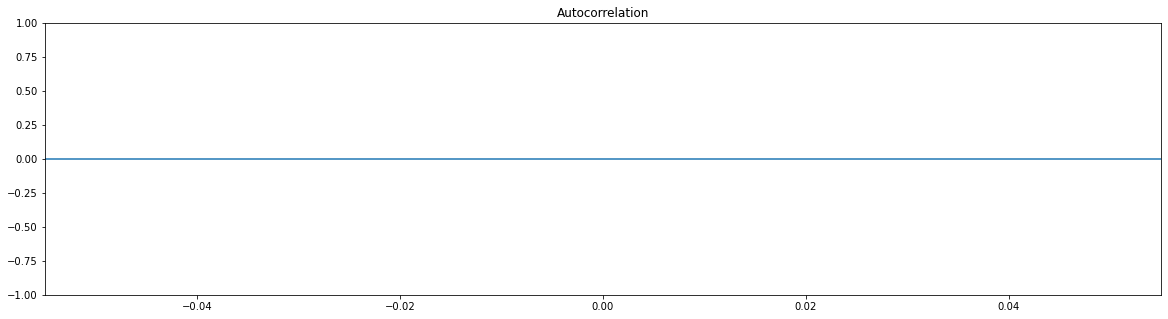

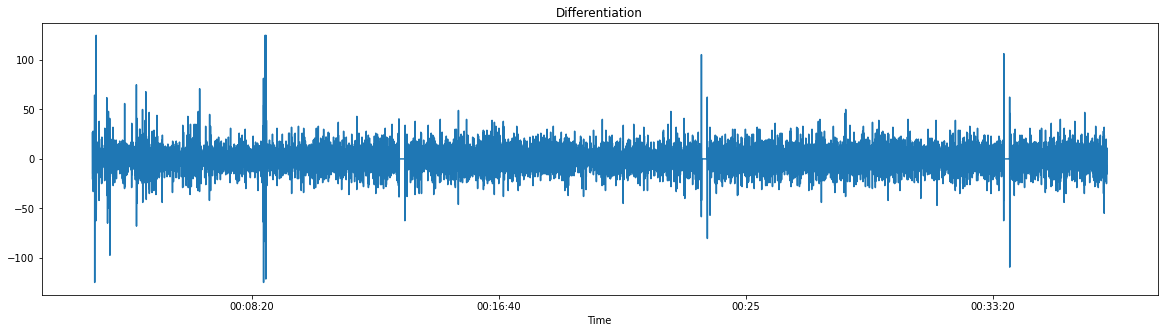

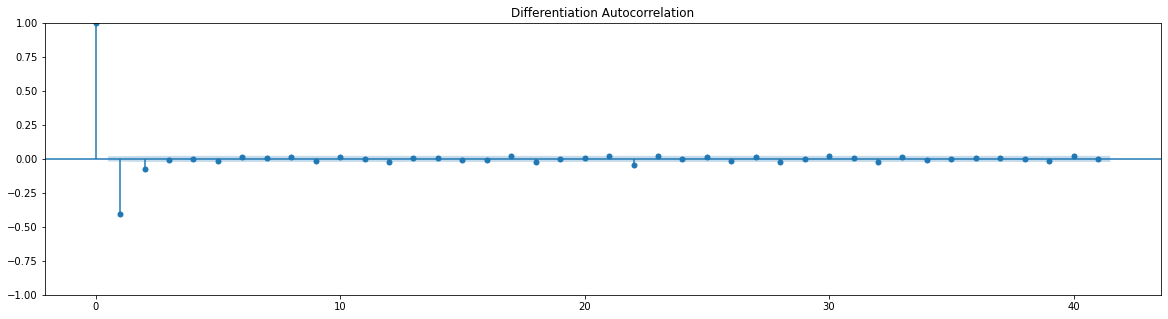

In [17]:
plot_acf(train);
plt.show()
train.diff().dropna().plot();
plt.title("Differentiation")
plt.show()
plot_acf(train.diff().dropna());
plt.title("Differentiation Autocorrelation")
plt.show()

### Análise

Filling not available data backward and forward

In [18]:
train = train.fillna(method='bfill').fillna(method='ffill')
train

Time
00:00:00            4.99084
00:00:00.200000     4.99084
00:00:00.400000     4.99084
00:00:00.600000     4.99084
00:00:00.800000     4.99084
                     ...   
00:37:09.400000   -15.00305
00:37:09.600000    -4.99084
00:37:09.800000    -4.99084
00:37:10            5.99817
00:37:10.200000    -8.98962
Name: EEG, Length: 11152, dtype: float64

<AxesSubplot:xlabel='Time'>

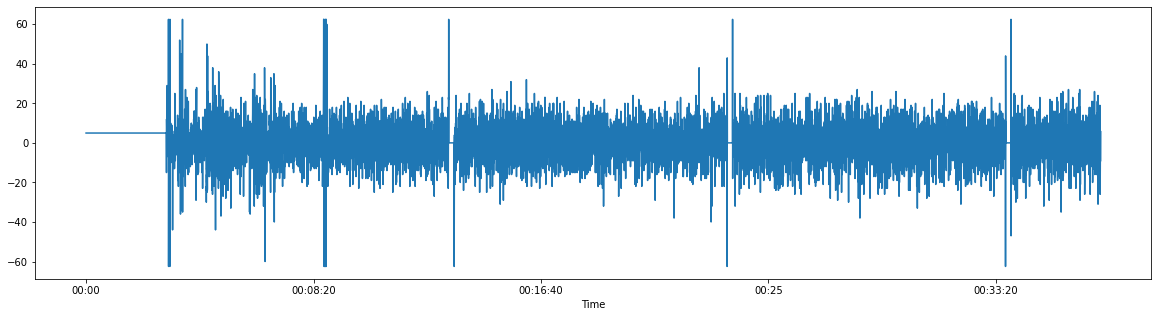

In [19]:
train.plot()

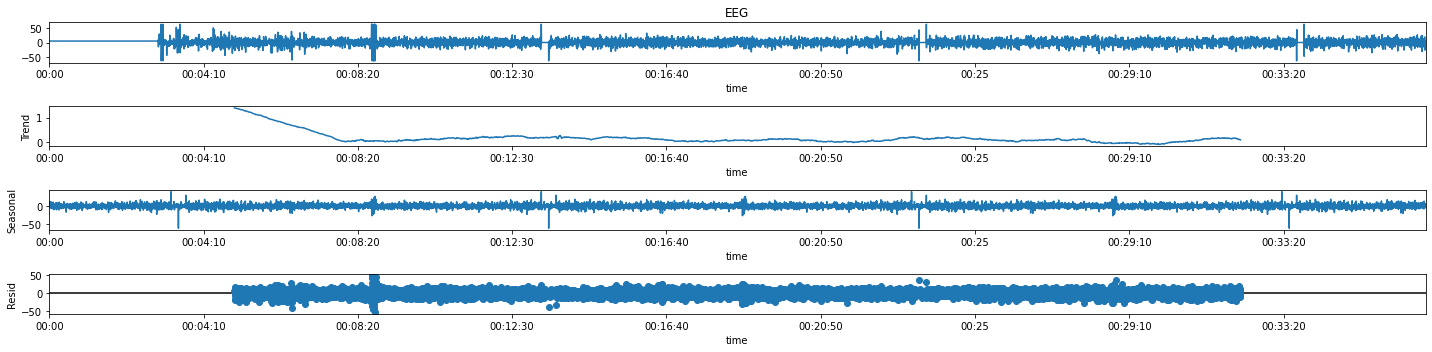

In [20]:
frequency = 200 # nanoseconds
minutes = 10 # 10 Minutes sazonality
train_decomp = tsa.seasonal_decompose(train, period=int(minutes*60*1000/frequency))
train_decomp.plot();

#### Stationarity

<AxesSubplot:xlabel='Time'>

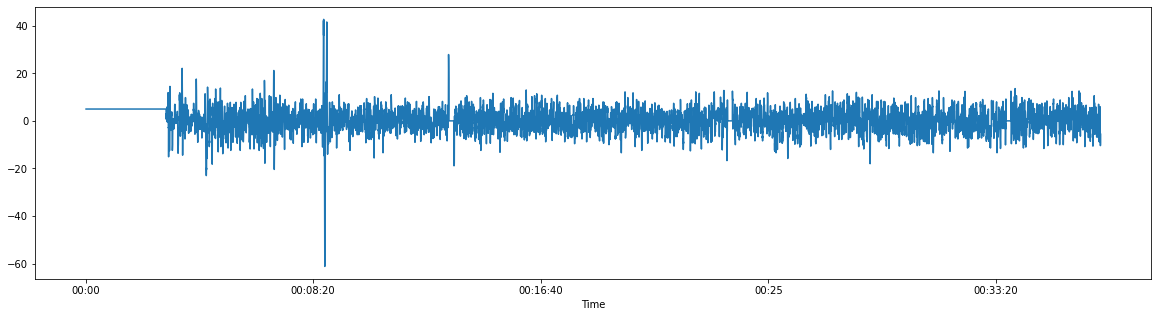

In [21]:
train.rolling(5).mean().plot()

<AxesSubplot:ylabel='Frequency'>

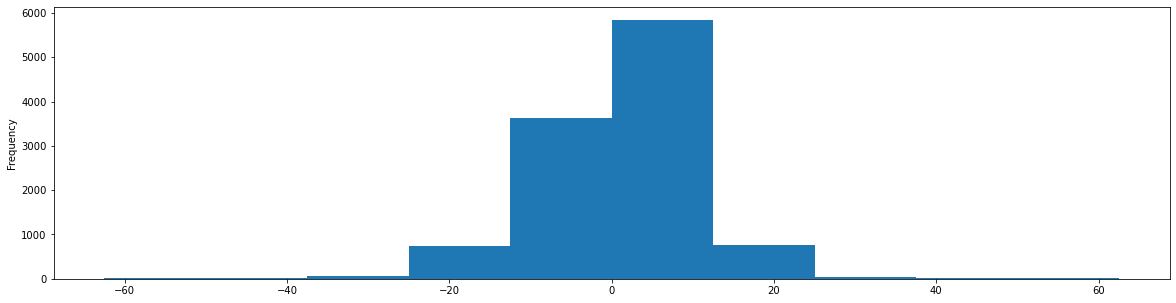

In [22]:
train.plot.hist()

#### Diferentiation 1st order (d)

<AxesSubplot:xlabel='Time'>

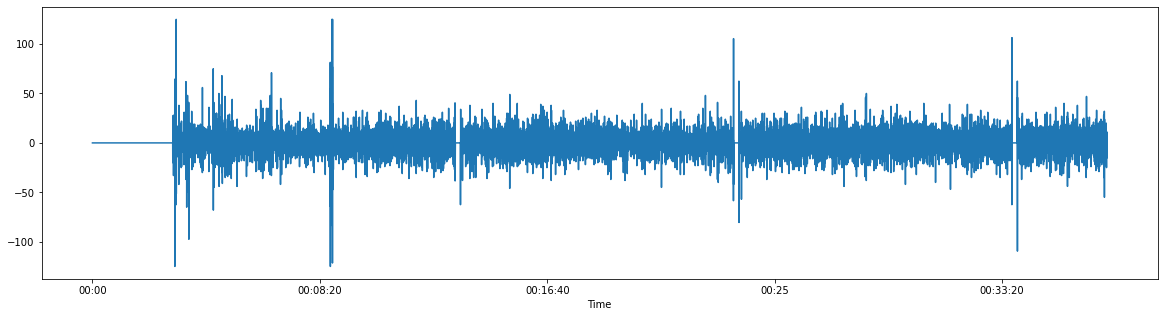

In [23]:
train.diff().plot()

<AxesSubplot:ylabel='Frequency'>

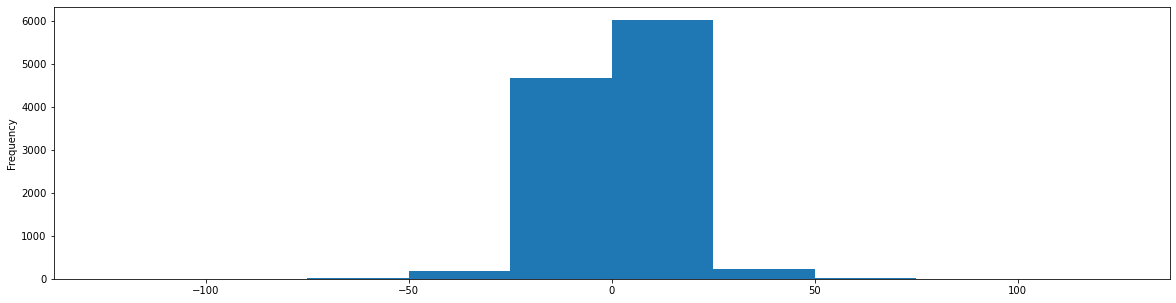

In [24]:
train.diff().plot.hist()

In [25]:
eegd1 = train.diff().dropna()

#### Autocorrelation

A correlation of a variable with itself at different times
is known as autocorrelation or serial correlation.

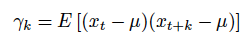

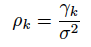

In [26]:
train.to_frame().corrwith(train.shift(-1))

EEG    0.162938
dtype: float64

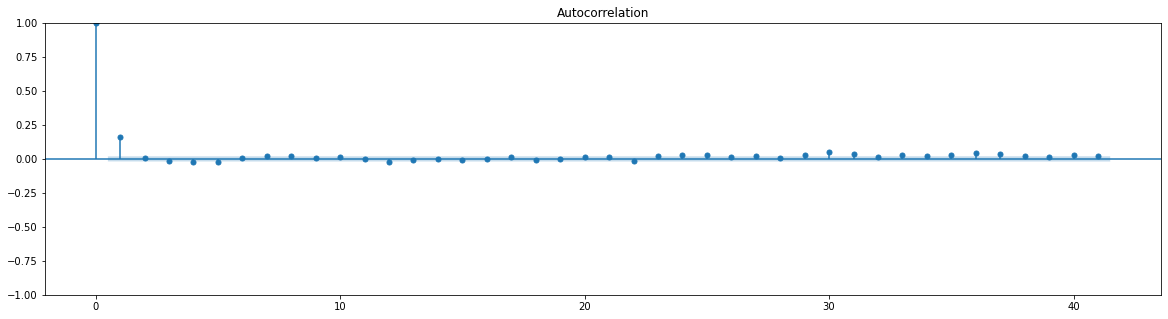

In [27]:
plot_acf(train);

In [28]:
train.to_frame().corrwith(eegd1.shift(-1))

EEG   -0.646931
dtype: float64

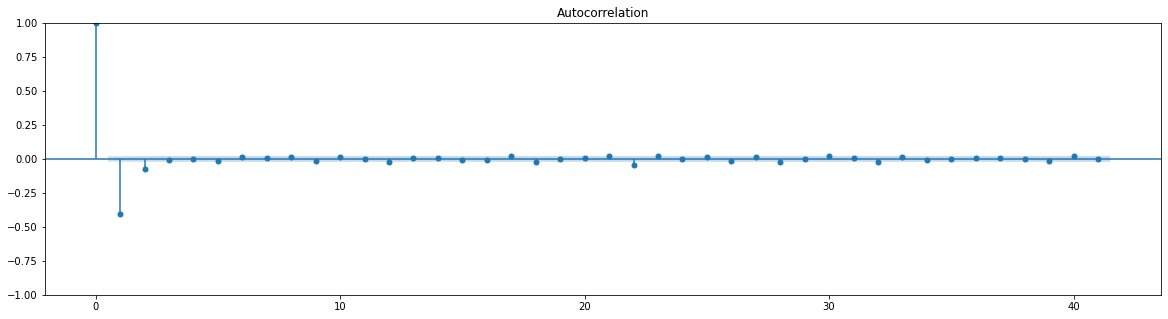

In [29]:
plot_acf(eegd1);

#### Partial Correlation

The partial autocorrelation at lag k is the correlation that
results after removing the effect of any correlations due to the terms at shorter
lags.

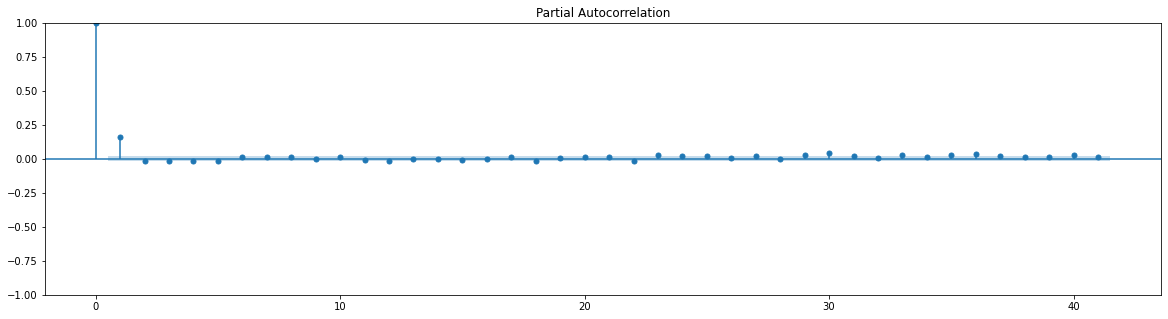

In [30]:
plot_pacf(train, method='ywm');

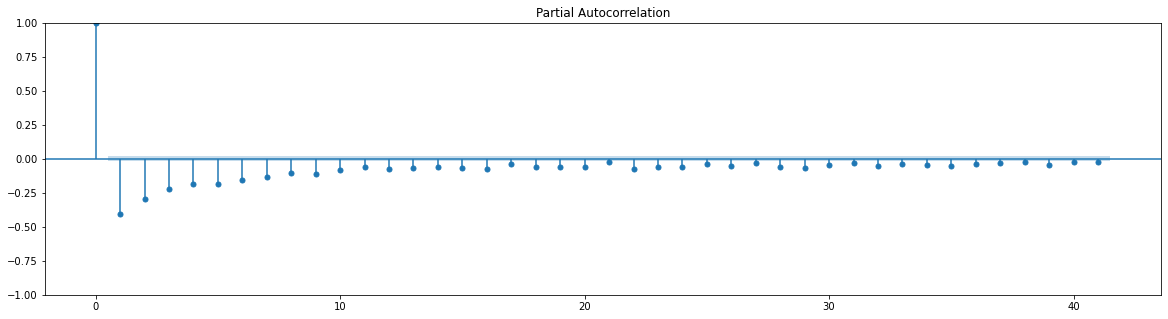

In [31]:
plot_pacf(eegd1, method='ywm');

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

### Feature Engineering

In [32]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [33]:
X_train = get_lags(train.to_frame(), 5)
X_val = get_lags(val.to_frame(), 5)
X_test = get_lags(test.to_frame(), 5)

In [34]:
X_train.head()

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5
Time,,,,,
00:00:01,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.200000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.400000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.600000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.800000,4.99084,4.99084,4.99084,4.99084,4.99084


In [35]:
X_val.head()

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5
Time,,,,,
00:37:11.400000,-4.99084,7.00549,-1.99939,-8.98962,-9.99695
00:37:11.600000,-7.00549,-4.99084,7.00549,-1.99939,-8.98962
00:37:11.800000,-8.01282,-7.00549,-4.99084,7.00549,-1.99939
00:37:12,-4.99084,-8.01282,-7.00549,-4.99084,7.00549
00:37:12.200000,-3.00671,-4.99084,-8.01282,-7.00549,-4.99084


In [36]:
X_test.head()

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5
Time,,,,,
00:55:46.800000,-1.99939,-1.99939,-5.99817,-3.00671,0.01526
00:55:47,0.01526,-1.99939,-1.99939,-5.99817,-3.00671
00:55:47.200000,4.01404,0.01526,-1.99939,-1.99939,-5.99817
00:55:47.400000,0.01526,4.01404,0.01526,-1.99939,-1.99939
00:55:47.600000,-1.99939,0.01526,4.01404,0.01526,-1.99939


In [37]:
y_train = train.to_frame().reindex(X_train.index)
y_val = val.to_frame().reindex(X_val.index)
y_test = test.to_frame().reindex(X_test.index)

In [38]:
y_train.head()

,EEG
Time,
00:00:01,4.99084
00:00:01.200000,4.99084
00:00:01.400000,4.99084
00:00:01.600000,4.99084
00:00:01.800000,4.99084


In [39]:
y_val.head()

,EEG
Time,
00:37:11.400000,-7.00549
00:37:11.600000,-8.01282
00:37:11.800000,-4.99084
00:37:12,-3.00671
00:37:12.200000,-5.99817


In [40]:
y_test.head()

,EEG
Time,
00:55:46.800000,0.01526
00:55:47,4.01404
00:55:47.200000,0.01526
00:55:47.400000,-1.99939
00:55:47.600000,1.99939


### KNN

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_nca_illustration_001.png)

![KNN](https://scikit-learn.org/stable/_images/sphx_glr_plot_regression_001.png)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

Hyperparameters:

* K 
* weights
* distance

In [41]:
import numpy as np

In [42]:
print(f'Train size: {len(train.index.values)}')
print(f'Val size: {len(val.index.values)}')

Train size: 11152
Val size: 5577


In [43]:
X = pd.concat([X_train,X_val])
X

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5
Time,,,,,
00:00:01,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.200000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.400000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.600000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.800000,4.99084,4.99084,4.99084,4.99084,4.99084
...,...,...,...,...,...
00:55:44.800000,-0.99206,-0.99206,0.99206,3.00671,0.01526
00:55:45,0.01526,-0.99206,-0.99206,0.99206,3.00671
00:55:45.200000,0.01526,0.01526,-0.99206,-0.99206,0.99206


In [44]:
X_train.index

Index([       00:00:01, 00:00:01.200000, 00:00:01.400000, 00:00:01.600000,
       00:00:01.800000,        00:00:02, 00:00:02.200000, 00:00:02.400000,
       00:00:02.600000, 00:00:02.800000,
       ...
       00:37:08.400000, 00:37:08.600000, 00:37:08.800000,        00:37:09,
       00:37:09.200000, 00:37:09.400000, 00:37:09.600000, 00:37:09.800000,
              00:37:10, 00:37:10.200000],
      dtype='object', name='Time', length=11147)

In [45]:
y = pd.concat([y_train,y_val])
y

,EEG
Time,
00:00:01,4.99084
00:00:01.200000,4.99084
00:00:01.400000,4.99084
00:00:01.600000,4.99084
00:00:01.800000,4.99084
...,...
00:55:44.800000,0.01526
00:55:45,0.01526
00:55:45.200000,0.01526


In [46]:
SEED = 42

In [47]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print('MSE: %2.3f' % mse)
    return mse

def MAE(y_true,y_pred):    
     mae = mean_absolute_error(y_true, y_pred)
     print('MAE: %2.3f' % mae)
     return mae

def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print('R2: %2.3f' % r2)
     return r2

def three_score(y_true,y_pred):    
    score = MAE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    score = R2(y_true,y_pred)
    score = MSE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    return score

def three_scorer():
    # return make_scorer(two_score, greater_is_better=True) # change for false if using MSE
    return make_scorer(three_score, greater_is_better=False) # change for false if using MSE


In [48]:
import random   

In [49]:
from sklearn.model_selection import PredefinedSplit
# Create a list where train data indices are -1 and validation data indices are 0 (2/3 = train and 1/3 = validation)
split_index = [-1 if index <= len(X)*2/3 else 0 for index in range(len(X))]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

for train_index, val_index in pds.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [50]:
def print_results_original_series(best_model, X_train, y_train, X_val, y_val, X_test, y_test):
    X_test = X_test.fillna(method='bfill').fillna(method='ffill')
    y_test = y_test.fillna(method='bfill').fillna(method='ffill')

    ax = None
    ax = y_train.rename(columns={'EEG': "train_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_train).flatten(), index=y_train.index, name="train_pred").plot(ax=ax, linewidth=linewidth)
    ax = y_val.rename(columns={'EEG': "val_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_val).flatten(), index=y_val.index, name="val_pred").plot(ax=ax, linewidth=linewidth)
    ax = y_test.rename(columns={'EEG': "test_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_test).flatten(), index=y_test.index, name="test_pred").plot(ax=ax, linewidth=linewidth)
    plt.legend(bbox_to_anchor=(1.1, 1), loc="upper right")
    r2  = r2_score(best_model.predict(X_test), y_test)
    mse = mean_squared_error(best_model.predict(X_test), y_test)
    mae = mean_absolute_error(best_model.predict(X_test), y_test)
    print(f"Test R2: {r2}")
    print(f"Test mse: {mse}")
    print(f"Test mae: {mae}")

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone
from scipy.stats import uniform

def train_validate_model(model, X_train_val, y_train_val, X_test, y_test, model_name=None, distributions={}, repetitions=10,
                        print_result=print_results_original_series):

    results = []
    best_models = []
    
    # Create a list where train data indices are -1 and validation data indices are 0 (2/3 = train and 1/3 = validation)
    split_index = [-1 if index <= len(X)*2/3 else 0 for index in range(len(X))]

    # Use the list to create PredefinedSplit
    pds = PredefinedSplit(test_fold = split_index)

    for train_index, val_index in pds.split(X_train_val):
        X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
        y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    for repetition in range(repetitions):
        print(f"Repetition: {str(repetition)}")
        SEED = random.seed(repetition)
        randGridS = RandomizedSearchCV(model, param_distributions=distributions, random_state = SEED, scoring=three_scorer(), 
                                       cv=pds, n_jobs=-1, verbose=2, return_train_score=True)
        res = randGridS.fit(X, y)
        best_params = res.best_params_
        best_model = res.best_estimator_
        best_score = res.best_score_
        r2  = r2_score(best_model.predict(X_val), y_val)
        mse = mean_squared_error(best_model.predict(X_val), y_val)
        mae = mean_absolute_error(best_model.predict(X_val), y_val)
        print(f"Best params: {best_params}")
        print(f"R2: {r2}")
        print(f"mse: {mse}")
        print(f"mae: {mae}")

        best_models.append(res)
        results.append({'model': model_name,
                        'repetition': repetition,
                        'val_r2': r2,
                        'val_mse': mse, 
                        'val_mae': mae,
                        'params': best_params})
        
    dataframe = pd.DataFrame(results).sort_values(['val_r2', 'val_mse', 'val_mae'], ascending=[False, True, True])
    print(f"Best params of all repetitions: {dataframe.iloc[0].params}")
    # SEED = random.seed(dataframe.iloc[0].repetition)
    best_model = clone(model).set_params(**resultados.iloc[0].params)
    best_model.fit(X, y)
    ax = None
    linewidth = 2

    print_result(best_model, X_train, y_train, X_val, y_val, X_test, y_test)
    return best_model, dataframe
    

In [ ]:
distributions = {'n_neighbors': np.random.randint(1, 1000, size=20),
                 'weights': ['uniform', 'distance']}

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()

In [352]:
distributions = {'n_neighbors':  [int(x) for x in np.linspace(start = 1, stop = 1000, num = 100)],
                 'weights': ['uniform', 'distance']}

In [353]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()

Repetition: 0
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 223}
R2: 0.9830193037991567
mse: 1.4555014820561532
mae: 0.02902948200724957
Repetition: 1
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 334}
R2: 0.9832068100157922
mse: 1.4395328478507399
mae: 0.03722519662197009
Repetition: 2
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 445}
R2: 0.9832068100157922
mse: 1.4395328478507399
mae: 0.03722519662197009
Repetition: 3
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 223}
R2: 0.9830193037991567
mse: 1.4555014820561532
mae: 0.02902948200724957
Repetition: 4
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 223}
R2: 0.9830193037991567
mse: 1.4555014820561532
mae: 

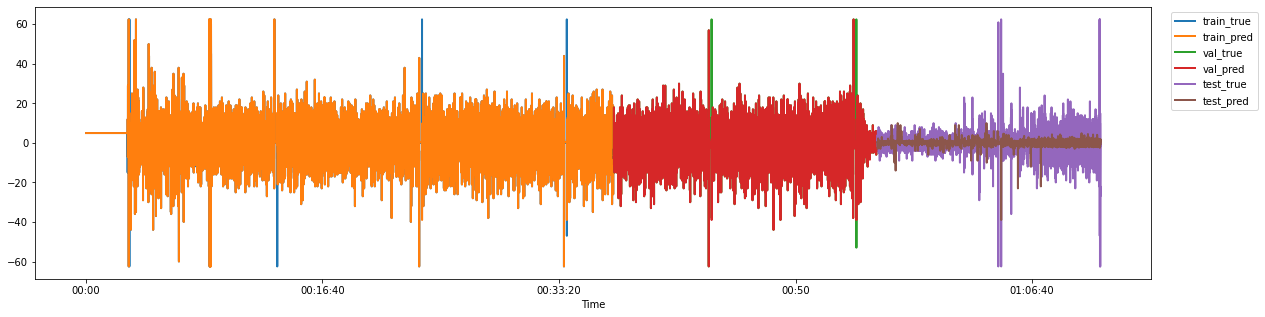

In [354]:
res, resultados = train_validate_model(model, X, y, X_test, y_test, 'KNN', distributions)

In [356]:
resultados

,model,repetition,val_r2,val_mse,val_mae,params
1,KNN,1,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 334}"
2,KNN,2,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
6,KNN,6,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 334}"
8,KNN,8,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
0,KNN,0,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
3,KNN,3,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
4,KNN,4,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
5,KNN,5,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
7,KNN,7,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
9,KNN,9,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"


E agora?

In [366]:
X_d1 = X.diff().fillna(method='bfill').fillna(method='ffill')
y_d1 = y.diff().fillna(method='bfill').fillna(method='ffill')
X_test_d1 = X_test.diff().fillna(method='bfill').fillna(method='ffill')
y_test_d1 = y_test.diff().fillna(method='bfill').fillna(method='ffill')

In [367]:
distributions

{'n_neighbors': [1, 112, 223, 334, 445, 556, 667, 778, 889, 1000],
 'weights': ['uniform', 'distance']}

In [378]:
def print_results_diff_series(best_model, X_train, y_train, X_val, y_val, X_test, y_test):
    X_test = X_test.fillna(method='bfill').fillna(method='ffill')
    y_test = y_test.fillna(method='bfill').fillna(method='ffill')

    ax = None
    ax = y_train.rename(columns={'EEG': "train_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_train).flatten(), index=y_train.index, name="train_pred").cumsum().plot(ax=ax, linewidth=linewidth)
    ax = y_val.rename(columns={'EEG': "val_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_val).flatten(), index=y_val.index, name="val_pred").cumsum().plot(ax=ax, linewidth=linewidth)
    ax = y_test.rename(columns={'EEG': "test_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_test).flatten(), index=y_test.index, name="test_pred").cumsum().plot(ax=ax, linewidth=linewidth)
    plt.legend(bbox_to_anchor=(1.1, 1), loc="upper right")
    r2  = r2_score(best_model.predict(X_test), y_test)
    mse = mean_squared_error(best_model.predict(X_test), y_test)
    mae = mean_absolute_error(best_model.predict(X_test), y_test)
    print(f"Test R2: {r2}")
    print(f"Test mse: {mse}")
    print(f"Test mae: {mae}")

Repetition: 0
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 334}
R2: -85.66282025948145
mse: 177.07859987916126
mae: 10.014200593359202
Repetition: 1
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 223}
R2: -77.52918918408162
mse: 177.35294592966838
mae: 10.014284166144057
Repetition: 2
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 445}
R2: -91.01991805793548
mse: 177.00406584918994
mae: 10.007956352900587
Repetition: 3
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 223}
R2: -77.52918918408162
mse: 177.35294592966838
mae: 10.014284166144057
Repetition: 4
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 223}
R2: -77.52918918408162
mse: 177.35294592966838
mae: 10.0

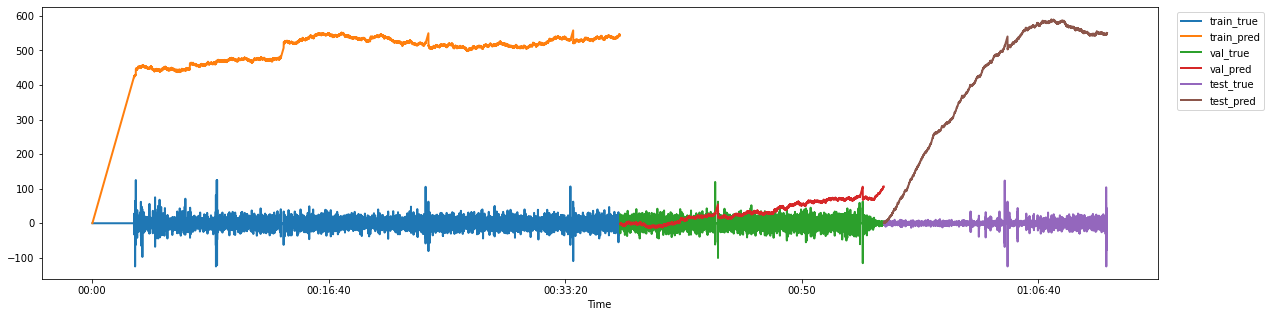

In [379]:
neighd1 = KNeighborsRegressor()

res_neigh_d1, resultados_neigh_d1 = train_validate_model(neighd1, X_d1, y_d1, X_test_d1, y_test_d1, 'KNN_d1', distributions,
                                                         print_result=print_results_diff_series)

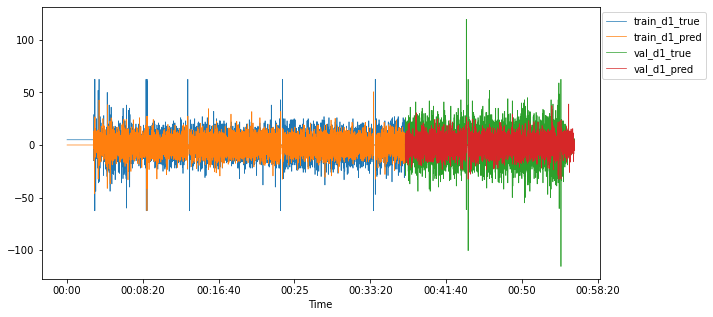

In [393]:
ax = None
linewidth = 0.7
ax = y_train.rename(columns={'EEG': "train_d1_true"}).plot(ax=ax, linewidth=linewidth)
ax = pd.Series(neigh.predict(X_train_d1).flatten(), index=y_train_d1.index, name="train_d1_pred").plot(ax=ax, linewidth=linewidth)
ax = y_val_d1.rename(columns={'EEG': "val_d1_true"}).plot(ax=ax, linewidth=linewidth)
ax = pd.Series(neigh.predict(X_val_d1).flatten(), index=y_val_d1.index, name="val_d1_pred").plot(ax=ax, linewidth=linewidth)
plt.legend(bbox_to_anchor=(1.2, 1), loc="upper right")

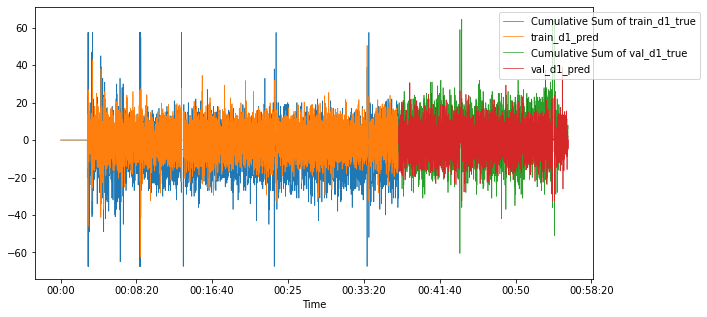

In [392]:
ax = None
linewidth = 0.7
ax = y_train_d1.rename(columns={'EEG': "Cumulative Sum of train_d1_true"}).cumsum().plot(ax=ax, linewidth=linewidth)
ax = pd.Series(neigh.predict(X_train_d1).flatten(), index=y_train_d1.index, name="train_d1_pred").plot(ax=ax, linewidth=linewidth)
ax = y_val_d1.rename(columns={'EEG': "Cumulative Sum of val_d1_true"}).cumsum().plot(ax=ax, linewidth=linewidth)
ax = pd.Series(neigh.predict(X_val_d1).flatten(), index=y_val_d1.index, name="val_d1_pred").plot(ax=ax, linewidth=linewidth)
plt.legend(bbox_to_anchor=(1.2, 1), loc="upper right")

Qual o problema dessa previsão?

 * Erro acumulado (problema em multi step recursivo)

In [382]:
pred_one = y_val.shift(1).reset_index(drop=True).add(pd.Series(neighd1.predict(X_val_d1).flatten(), name='EEG'),axis=0)

In [383]:
pred_one

,EEG
0,NaN
1,-17.255582
2,-0.086321
3,-4.813738
4,-10.034704
...,...
5570,-2.994496
5571,2.002478
5572,3.765586
5573,-4.447926


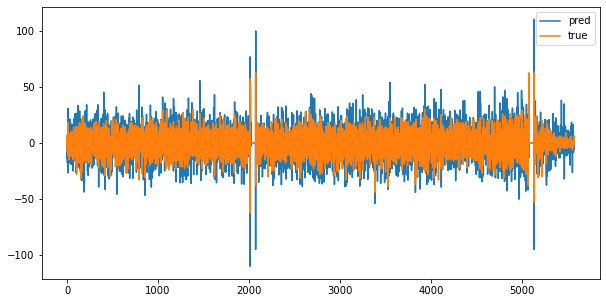

In [384]:
fig, ax = plt.subplots()
ax.plot(pred_one, label='pred')
ax.plot(y_val.reset_index(drop=True), label='true')
plt.legend()

In [385]:
pred_one

,EEG
0,NaN
1,-17.255582
2,-0.086321
3,-4.813738
4,-10.034704
...,...
5570,-2.994496
5571,2.002478
5572,3.765586
5573,-4.447926


In [387]:
print('EEG pred_one - KNN model Results')
print(r2_score(pred_one.iloc[1:-1], y_val.iloc[1:-1]))
print(mean_squared_error(pred_one.iloc[1:-1], y_val.iloc[1:-1]))
print(mean_absolute_error(pred_one.iloc[1:-1], y_val.iloc[1:-1]))
results['KNN D1 ONE'] = {'r2':r2_score(pred_one.iloc[1:-1], y_val.iloc[1:-1]), \
                 'mse': mean_squared_error(pred_one.iloc[1:-1], y_val.iloc[1:-1]), 
                 'mae': mean_absolute_error(pred_one.iloc[1:-1], y_val.iloc[1:-1])}


EEG pred_one - KNN model Results
-0.9422565150745388
378.13346420224957
14.490483838948538


In [388]:
residuos = neighd1.predict(X_val_d1).flatten() - y_val_d1.reset_index(drop=True).values.flatten()

<AxesSubplot:>

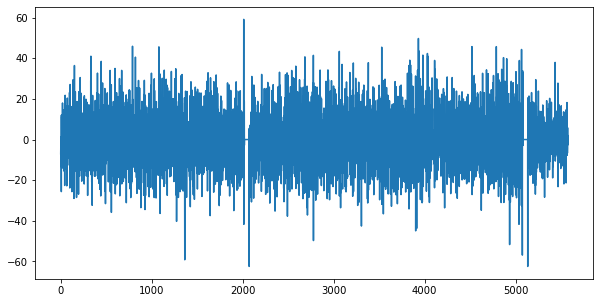

In [389]:
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

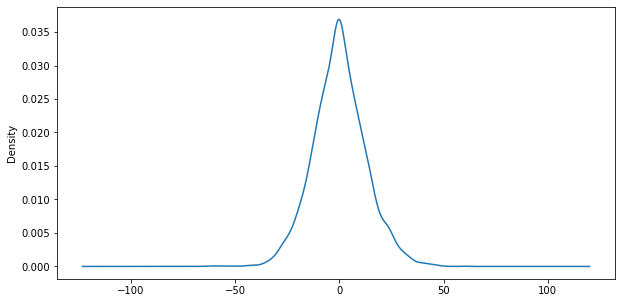

In [390]:
pd.Series(residuos).plot.kde()

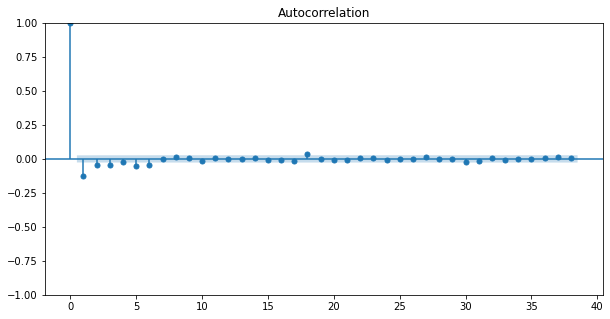

In [391]:
plot_acf(residuos);

### SVR

![SVC](https://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_001.png)

![SVR](https://scikit-learn.org/stable/_images/sphx_glr_plot_svm_regression_001.png)

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR

In [53]:
distributions = {'C': [x for x in np.linspace(start = 1, stop = 10, num = 100)],
                 'epsilon': [x for x in np.linspace(start = .1, stop = 1, num = 100)],
                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [54]:
from sklearn.svm import SVR

In [55]:
res, resultados = train_validate_model(SVR(), X, y, X_test, y_test, 'SVR', distributions)

Repetition: 0
Fitting 1 folds for each of 10 candidates, totalling 10 fits


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'kernel': 'rbf', 'epsilon': 0.28181818181818186, 'C': 1.2727272727272727}
R2: -38.66072595894638
mse: 85.75891506429055
mae: 6.889338360518228
Repetition: 1
Fitting 1 folds for each of 10 candidates, totalling 10 fits


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'kernel': 'rbf', 'epsilon': 0.1, 'C': 9.727272727272727}
R2: -25.151966377025744
mse: 83.88656740074534
mae: 6.776132637453685
Repetition: 2
Fitting 1 folds for each of 10 candidates, totalling 10 fits


In [95]:
print('El Nino - SVR model Results')
print(r2_score(regr.predict(X_test), y_test))
print(mean_squared_error(regr.predict(X_test), y_test))
print(mean_absolute_error(regr.predict(X_test), y_test))
results['SVR'] = {'r2':r2_score(regr.predict(X_test), y_test), \
                 'mse': mean_squared_error(regr.predict(X_test), y_test), 
                 'mae': mean_absolute_error(regr.predict(X_test), y_test)}

El Nino - SVR model Results
-8.599835673898674
28.087809531214823
2.7669177369304196


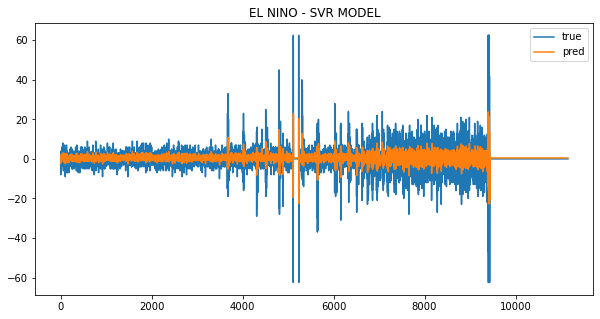

In [97]:
fig, ax = plt.subplots()
ax.plot(y_test.reset_index(drop=True), label='true')
ax.plot(regr.predict(X_test), label='pred')
plt.title('EL NINO - SVR MODEL')
plt.legend()

In [583]:
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from scipy.stats import uniform

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if index in train.index else 0 for index in train_plus_val_indices]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

In [98]:

parameters = {'kernel':['linear','rbf'], 'C':[0.1,1,10]}
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
regr2 = SVR()
regrGS = RandomizedSearchCV(regr2, parameters, cv=pds, n_jobs=-1)

res = regrGS.fit(X_train, y_train)
print(res.best_score_)
print(res.best_params_)
print('SVR GS - model Results')
print('r2' , r2_score(res.predict(X_test), y_test))
print('mse' ,mean_squared_error(res.predict(X_test), y_test))
print('mae', mean_absolute_error(res.predict(X_test), y_test))
results['SVRGS'] = {'r2':r2_score(res.predict(X_test), y_test), \
                 'mse': mean_squared_error(res.predict(X_test), y_test), 
                 'mae': mean_absolute_error(res.predict(X_test), y_test)}
%%time

In [99]:
pd.DataFrame(results)

,KNN,KNN D1,KNN D1 ONE,SVR,SVRGS
r2,-0.764809,-0.764809,-0.684845,-8.599836,-10.187646
mse,48.807563,48.807563,109.502158,28.087810,26.675165
mae,4.318033,4.318033,5.790172,2.766918,2.693775


In [ ]:
X = get_lags(co2, 5)
y = co2.reindex(X.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2)

In [ ]:
regrco2 = SVR(kernel='linear')
regrco2.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(kernel='linear')

In [ ]:
print('SVR GS - model Results')
print('r2' , r2_score(regrco2.predict(X_test), y_test))
print('mse' ,mean_squared_error(regrco2.predict(X_test), y_test))
print('mae', mean_absolute_error(regrco2.predict(X_test), y_test))
resultsco2['SVRGS'] = {'r2':r2_score(regrco2.predict(X_test), y_test), \
                 'mse': mean_squared_error(regrco2.predict(X_test), y_test), 
                 'mae': mean_absolute_error(regrco2.predict(X_test), y_test)}


SVR GS - model Results
r2 0.9901566847904703
mse 0.23719501168606366
mae 0.37552955540609895


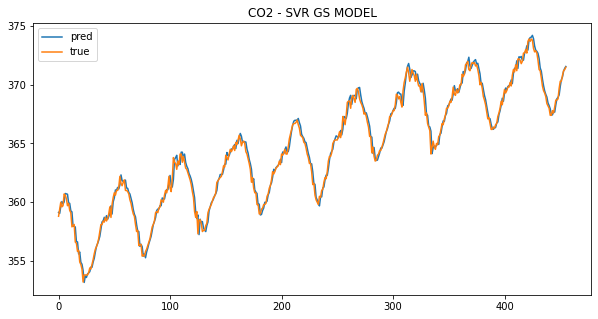

In [ ]:
fig, ax = plt.subplots()
ax.plot(regrco2.predict(X_test), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('CO2 - SVR GS MODEL')
plt.legend()

In [ ]:
pd.DataFrame(resultsco2)

,KNN,KNN D1,KNN D1 ONE,SVRGS
r2,-45.318270,-45.318270,0.985402,0.990157
mse,52.555341,52.555341,0.353482,0.237195
mae,5.847865,5.847865,0.455441,0.375530


Overfitting ?

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

In [ ]:
len(y)

2279

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    SVR(kernel='linear'), X, y, train_sizes=[50,100,150,200,250,300,350,384], cv=TimeSeriesSplit())
    #SVR(kernel='linear'), X, y, train_sizes=[np.round(np.array(list(range(0.1,1,0.1))) * len(y))], cv=TimeSeriesSplit())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

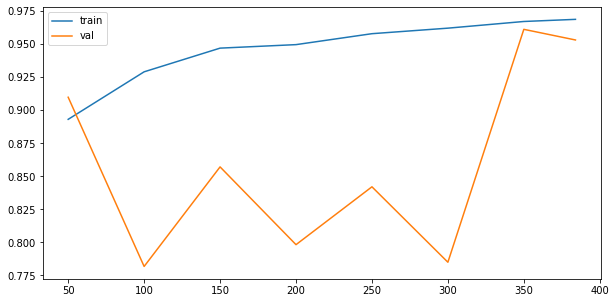

In [ ]:
pd.Series(train_scores.mean(axis=1), index=train_sizes).plot(label='train')
pd.Series(valid_scores.mean(axis=1), index=train_sizes).plot(label='val')
plt.legend()

# Show me the money 🤑

## Prices

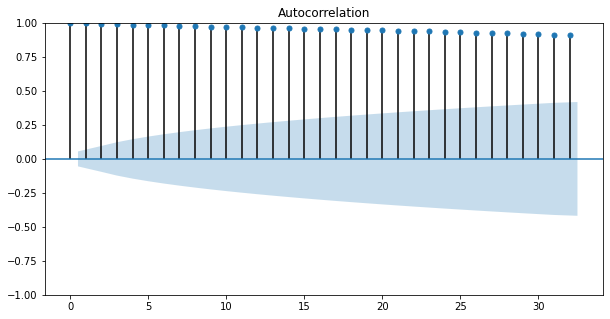

In [ ]:
plot_acf(prices['Adj Close']);

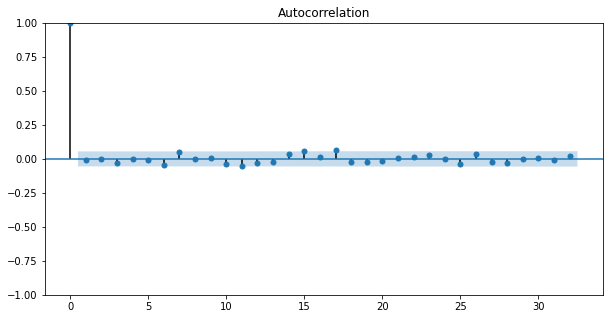

In [ ]:
plot_acf(prices['Adj Close'].diff().fillna(0));

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


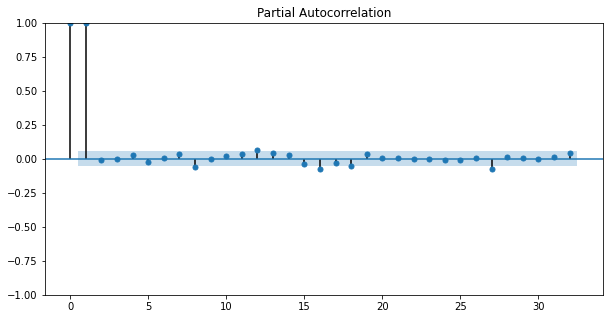

In [ ]:
plot_pacf(prices['Adj Close']);

### FE

In [ ]:
X = get_lags(pd.DataFrame(prices['Adj Close']), 7)
y = prices['Adj Close'].reindex(X.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1006, 7)
(1006,)
(252, 7)
(252,)


In [ ]:
resultsprices = {}

## KNN

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=2, weights='distance')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

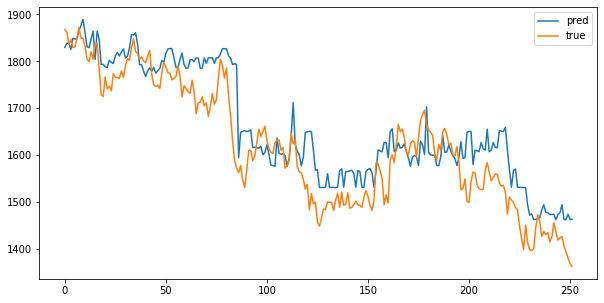

In [ ]:
pd.Series(y_pred).plot(label='pred')
y_test.reset_index(drop=True).plot(label='true')
plt.legend()

In [ ]:
print('Prices - KNN model Results')
print('r2' ,r2_score(neigh.predict(X_test), y_test))
print('mse' ,mean_squared_error(neigh.predict(X_test), y_test))
print('mae', mean_absolute_error(neigh.predict(X_test), y_test))
resultsprices['KNN'] = {'r2':r2_score(neigh.predict(X_test), y_test), \
                 'mse': mean_squared_error(neigh.predict(X_test), y_test), 
                 'mae': mean_absolute_error(neigh.predict(X_test), y_test)}

Prices - KNN model Results
r2 0.7096013960119982
mse 4210.650043299322
mae 52.80703192035267


In [ ]:
X_train_d1 = X_train.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_test_d1 = y_test.diff().dropna()

In [ ]:
neighd1 = KNeighborsRegressor(n_neighbors=2, weights='distance')
neighd1.fit(X_train_d1, y_train_d1)
y_pred_d1 = neighd1.predict(X_test_d1)

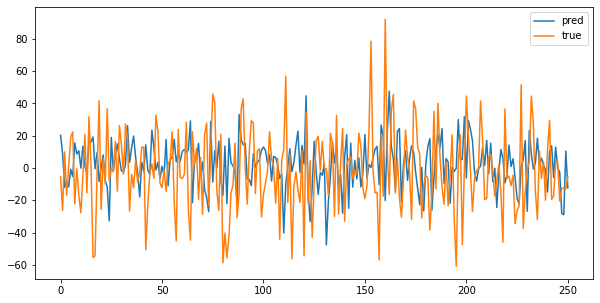

In [ ]:
pd.Series(y_pred_d1).plot(label='pred')
y_test_d1.reset_index(drop=True).plot(label='true')
plt.legend()

In [ ]:
pred_one = y_test.shift(1).reset_index(drop=True).add(pd.Series(neighd1.predict(X_test_d1).flatten(), name='prices'),axis=0)

In [ ]:
print('Prices pred_one - KNN model Results')
print(r2_score(pred_one.iloc[1:-1], y_test.iloc[1:-1]))
print(mean_squared_error(pred_one.iloc[1:-1], y_test.iloc[1:-1]))
print(mean_absolute_error(pred_one.iloc[1:-1], y_test.iloc[1:-1]))
resultsprices['KNN D1 ONE'] = {'r2':r2_score(pred_one.iloc[1:-1], y_test.iloc[1:-1]), \
                 'mse': mean_squared_error(pred_one.iloc[1:-1], y_test.iloc[1:-1]), 
                 'mae': mean_absolute_error(pred_one.iloc[1:-1], y_test.iloc[1:-1])}


Prices pred_one - KNN model Results
0.9495759221725417
854.7551648676425
22.534678606044853


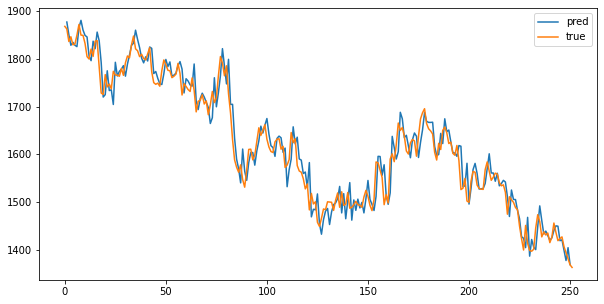

In [ ]:
fig, ax = plt.subplots()
ax.plot(pred_one, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.legend()

## SVR

In [ ]:
regr = SVR(C=1.0, epsilon=0.2, kernel='linear')

In [ ]:
regr.fit(X_train, y_train)

SVR(epsilon=0.2, kernel='linear')

In [ ]:
y_pred = regr.predict(X_test)

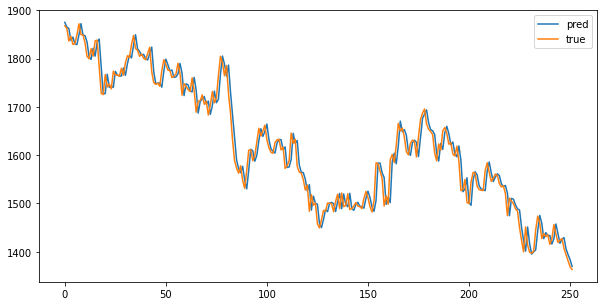

In [ ]:
pd.Series(y_pred).plot(label='pred')
y_test.reset_index(drop=True).plot(label='true')
plt.legend()

In [ ]:
print('Prices - SVR model Results')
print('r2' ,r2_score(y_pred, y_test))
print('mse' ,mean_squared_error(y_pred, y_test))
print('mae', mean_absolute_error(y_pred, y_test))
resultsprices['SVR'] = {'r2':r2_score(y_pred, y_test), \
                 'mse': mean_squared_error(y_pred, y_test), 
                 'mae': mean_absolute_error(y_pred, y_test)}

Prices - SVR model Results
r2 0.963271964236085
mse 613.071918661295
mae 19.234203976836564


Fiquei rico? 

Negociar ações é mais complicado do que fazer previsão de um passo a frente. 

O retorno geralmente ocorre a longo prazo, por isso um dos desafios é prever vários passos a frente.

In [ ]:
X_train

,Adj Close-1,Adj Close-2,Adj Close-3,Adj Close-4,Adj Close-5,Adj Close-6,Adj Close-7
Date,,,,,,,
2017-04-24,785.365479,773.101074,789.745789,795.439941,817.340698,809.456482,797.191956
2017-04-25,798.067932,785.365479,773.101074,789.745789,795.439941,817.340698,809.456482
2017-04-26,825.225159,798.067932,785.365479,773.101074,789.745789,795.439941,817.340698
2017-04-27,818.654846,825.225159,798.067932,785.365479,773.101074,789.745789,795.439941
2017-04-28,842.307800,818.654846,825.225159,798.067932,785.365479,773.101074,789.745789
...,...,...,...,...,...,...,...
2021-04-08,1892.730225,1907.099121,1839.218506,1807.507812,1799.580200,1770.895752,1786.681030
2021-04-09,1866.965332,1892.730225,1907.099121,1839.218506,1807.507812,1799.580200,1770.895752
2021-04-12,1845.164185,1866.965332,1892.730225,1907.099121,1839.218506,1807.507812,1799.580200


In [ ]:
get_lags(pd.DataFrame(prices['Adj Close']), -7)

,Adj Close+1,Adj Close+2,Adj Close+3,Adj Close+4,Adj Close+5,Adj Close+6,Adj Close+7
Date,,,,,,,
2017-04-11,809.456482,817.340698,795.439941,789.745789,773.101074,785.365479,798.067932
2017-04-12,817.340698,795.439941,789.745789,773.101074,785.365479,798.067932,825.225159
2017-04-13,795.439941,789.745789,773.101074,785.365479,798.067932,825.225159,818.654846
2017-04-18,789.745789,773.101074,785.365479,798.067932,825.225159,818.654846,842.307800
2017-04-19,773.101074,785.365479,798.067932,825.225159,818.654846,842.307800,859.390503
...,...,...,...,...,...,...,...
2022-03-25,1426.500000,1456.000000,1436.500000,1419.000000,1423.500000,1427.000000,1406.500000
2022-03-28,1456.000000,1436.500000,1419.000000,1423.500000,1427.000000,1406.500000,1394.000000
2022-03-29,1436.500000,1419.000000,1423.500000,1427.000000,1406.500000,1394.000000,1381.500000


In [ ]:
y_train_multi = get_lags(pd.DataFrame(y_train), -7)
y_test_multi = get_lags(pd.DataFrame(y_test), -7)

In [ ]:
X_train_multi, y_train_multi = X_train.align(y_train_multi, join='inner', axis=0) 
X_test_multi, y_test_multi = X_test.align(y_test_multi, join='inner', axis=0) 

In [ ]:
X_train_multi.index is y_train_multi.index

True

In [ ]:
X_test_multi.index is y_test_multi.index

True

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
regr_multi = MultiOutputRegressor(LinearSVR(C=1.0, epsilon=0.2))

In [ ]:
regr_multi.fit(X_train_multi, y_train_multi)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

MultiOutputRegressor(estimator=LinearSVR(epsilon=0.2))

In [ ]:
y_pred_multi = regr_multi.predict(X_test_multi)

In [ ]:
regr_multi.predict(X_test_multi).shape

(245, 7)

In [ ]:
print('Prices - SVR multi model Results')
print('r2' ,r2_score(y_pred_multi, y_test_multi))
print('mse' ,mean_squared_error(y_pred_multi, y_test_multi))
print('mae', mean_absolute_error(y_pred_multi, y_test_multi))
resultsprices['SVR multi'] = {'r2':r2_score(y_pred_multi, y_test_multi), \
                 'mse': mean_squared_error(y_pred_multi, y_test_multi), 
                 'mae': mean_absolute_error(y_pred_multi, y_test_multi)}

Prices - SVR multi model Results
r2 0.3627946541123513
mse 9065.061796620957
mae 77.19764370745118


In [ ]:
  np.random.randint(1,100,5)

array([17, 40, 65, 34, 22])

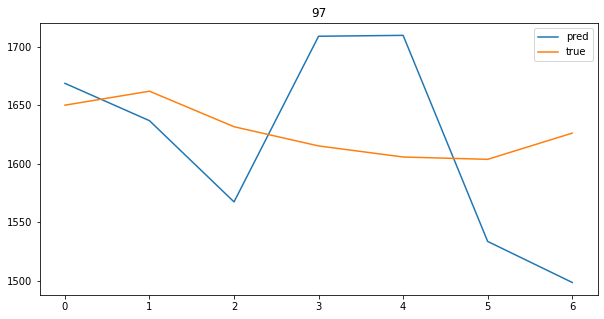

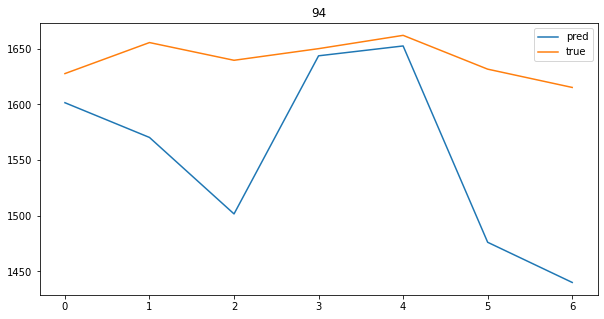

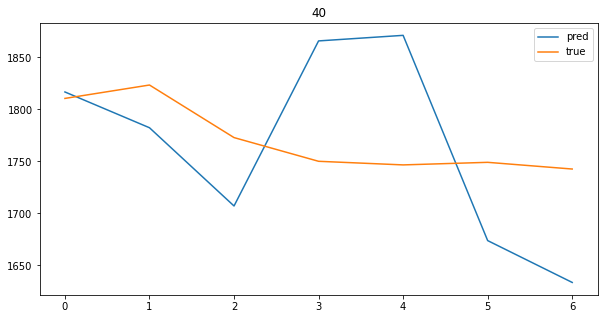

In [ ]:
for day in np.random.randint(1,100,3):
  fig, ax = plt.subplots()
  pd.Series(y_pred_multi[day]).plot(label='pred')
  pd.Series(pd.DataFrame(y_test_multi).reset_index(drop=True).loc[day].values).plot(label='true')
  plt.title(day)
  plt.legend()

In [ ]:
pd.DataFrame(resultsprices)

,KNN,KNN D1 ONE,SVR,SVR multi
r2,0.709601,0.949576,0.963272,0.362795
mse,4210.650043,854.755165,613.071919,9065.061797
mae,52.807032,22.534679,19.234204,77.197644


## MLP

In [52]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

https://pytorch.org/tutorials/beginner/basics/intro.html

### Normalization

In [56]:
X_train_norm = X_train.sub(X_train.mean()).div(X_train.std())
X_val_norm = X_val.sub(X_val.mean()).div(X_val.std())
X_test_norm = X_test.sub(X_train.mean()).div(X_train.std())

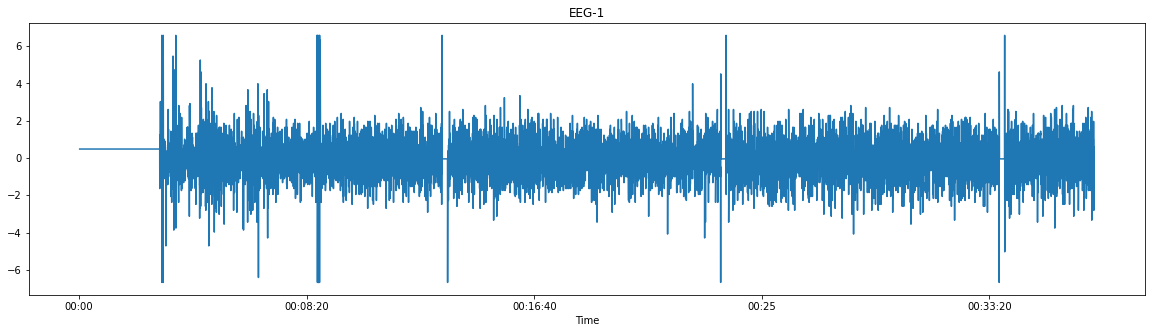

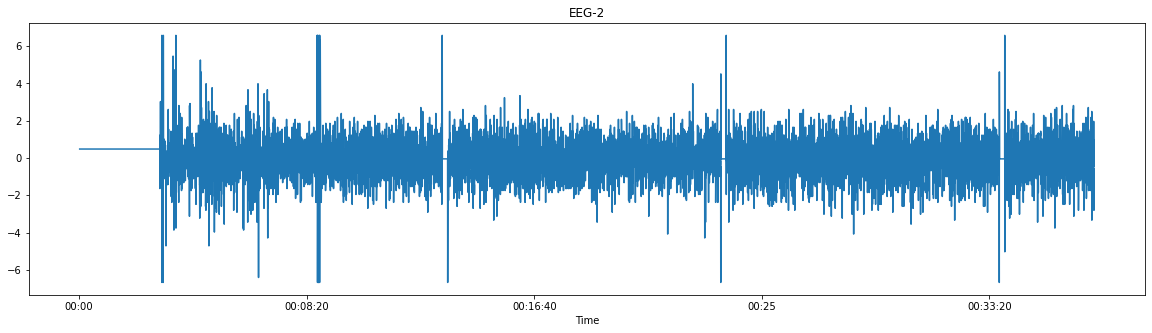

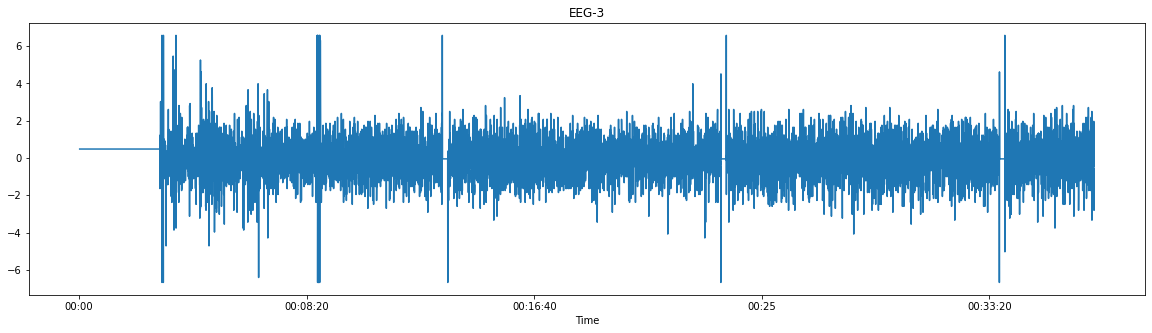

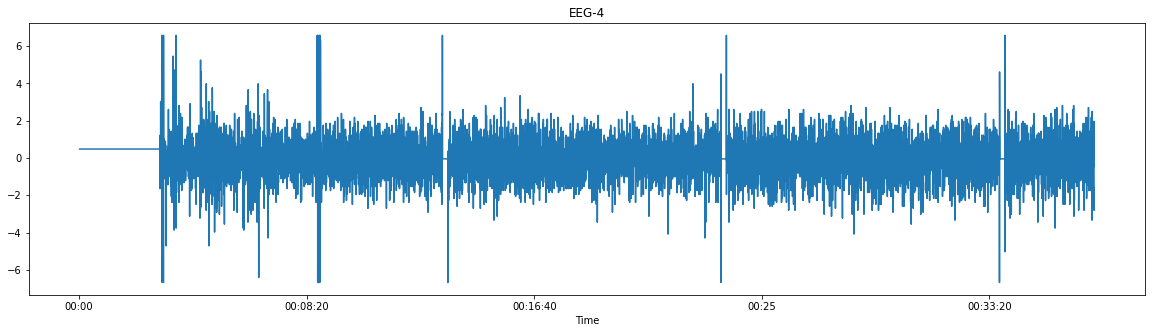

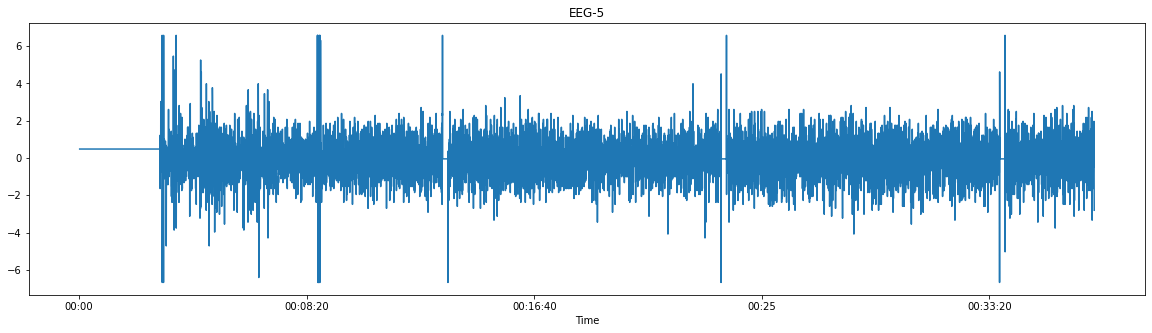

In [61]:
for column in X_train_norm.columns:
    X_train_norm[column].plot()
    plt.title(f'{column}')
    plt.show()

<AxesSubplot:title={'center':'train'}, ylabel='Frequency'>

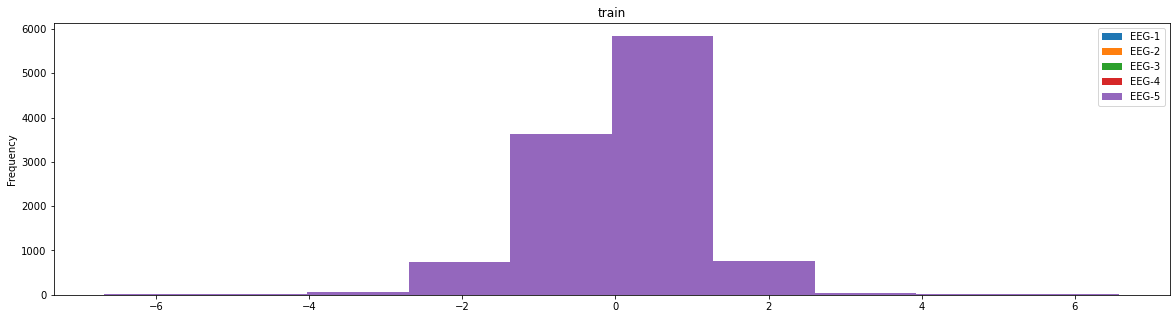

In [62]:
X_train_norm.plot.hist(title='train')

<AxesSubplot:title={'center':'test'}, ylabel='Frequency'>

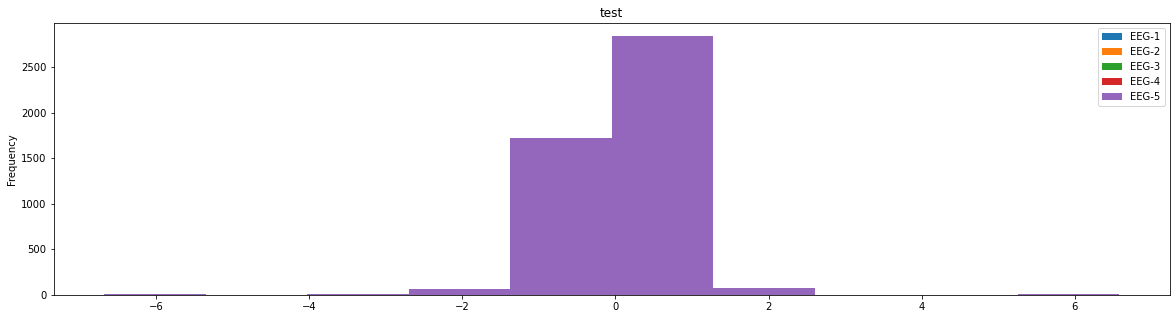

In [63]:
X_test_norm.plot.hist(title='test')

### Tensors

![](https://miro.medium.com/max/654/1*8jdzMrA33Leu3j3F6A8a3w.png)

#### Batches

In [65]:
training_data = torch.tensor(pd.concat([X_train_norm, y_train], axis=1).values)
validation_data = torch.tensor(pd.concat([X_val_norm, y_val], axis=1).values)
testing_data = torch.tensor(pd.concat([X_test_norm, y_test], axis=1).values)

In [66]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
val_dataloader = DataLoader(validation_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=16, shuffle=False)

### ANN

In [70]:
class OP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(5,1)
    
  def forward(self, X):
    out = torch.relu(self.fc(X))
    return out

In [71]:
one_neuron = OP()
print(one_neuron(torch.tensor(X_train.iloc[0]).float()))
print(y_train.iloc[0])

tensor([3.3904], grad_fn=<ReluBackward0>)
EEG    4.99084
Name: 00:00:01, dtype: float64


In [72]:
one_neuron = OP()
epochs = 50
loss_fn = nn.MSELoss()
optimizer = optim.SGD(one_neuron.parameters(), lr=0.001)

d:\Users\dav\anaconda3\envs\pos\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Users\dav\anaconda3\envs\pos\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch1, loss 89.29571128256785
Epoch2, loss 89.2253017826039
Epoch3, loss 88.62726955845552
Epoch4, loss 88.19591369646383
Epoch5, loss 88.10779896887337
Epoch6, loss 88.08843977124546
Epoch7, loss 88.08356519187754
Epoch8, loss 88.08218918228722
Epoch9, loss 88.08221200506178
Epoch10, loss 88.08299508964485
Epoch11, loss 88.08242735317995
Epoch12, loss 88.08306534770058
Epoch13, loss 88.08245558342983
Epoch14, loss 88.08319118109075
Epoch15, loss 88.08250304616165
Epoch16, loss 88.08316260891588
Epoch17, loss 88.08258027022163
Epoch18, loss 88.0832188530495
Epoch19, loss 88.08251320019129
Epoch20, loss 88.08320772451171
Epoch21, loss 88.08251737094507
Epoch22, loss 88.08318833193316
Epoch23, loss 88.08255045040052
Epoch24, loss 88.08317701775084
Epoch25, loss 88.08258415337444
Epoch26, loss 88.08321990277966
Epoch27, loss 88.08252083868258
Epoch28, loss 88.08316983718697
Epoch29, loss 88.08254513010874
Epoch30, loss 88.08317497830137
Epoch31, loss 88.08258271578651
Epoch32, loss 88.08

<AxesSubplot:>

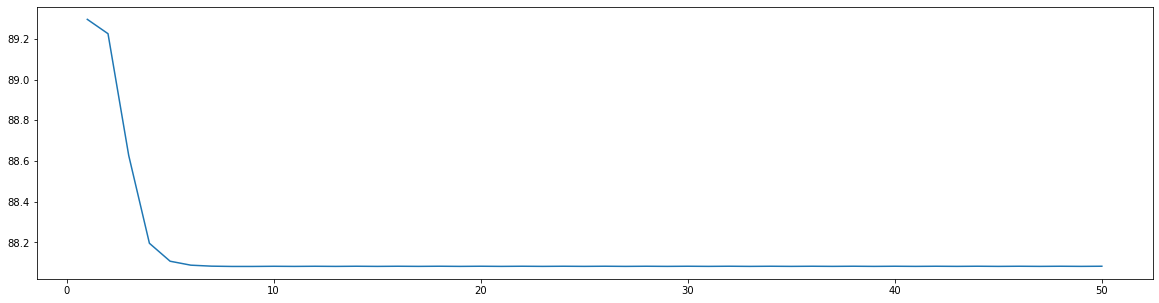

In [74]:
history = {}
for epoch in range(1, epochs+1):
  loss_train = 0.0
  for train_data in train_dataloader:
    x = train_data[:,:5].float()
    y = train_data[:,5].float()
  
    #forward pass
    outputs = one_neuron(x)

    #loss measure
    loss = loss_fn(outputs,y)

    #backward pass
    optimizer.zero_grad() # pára o autograd
    loss.backward() # executa o backpropagation
    optimizer.step() # atualiza os pesos

    loss_train += loss.item() # soma os erros para obter o erro total

  print('Epoch{}, loss {}'.format(epoch, loss_train / len(train_dataloader))) # apresenta o erro médio da época
  history[epoch] = loss_train / len(train_dataloader)

pd.Series(history).plot()



In [75]:
one_neuron.eval() #desliga o treinamento do modelo
results = []
for test_data in test_dataloader:
    x = test_data[:,:5].float()
    y = test_data[:,5].float()
    
    y_pred = one_neuron(x)
    results.extend(y_pred.flatten().detach().numpy())
#pd.DataFrame(results).plot()
results[:10]

[0.0,
 0.0,
 0.13282114,
 0.28684315,
 0.2312724,
 0.44949818,
 0.38027227,
 0.29327485,
 0.38362724,
 0.7583412]

In [80]:
y_test = y_test.fillna(method='bfill').fillna(method='ffill')

<AxesSubplot:xlabel='Time'>

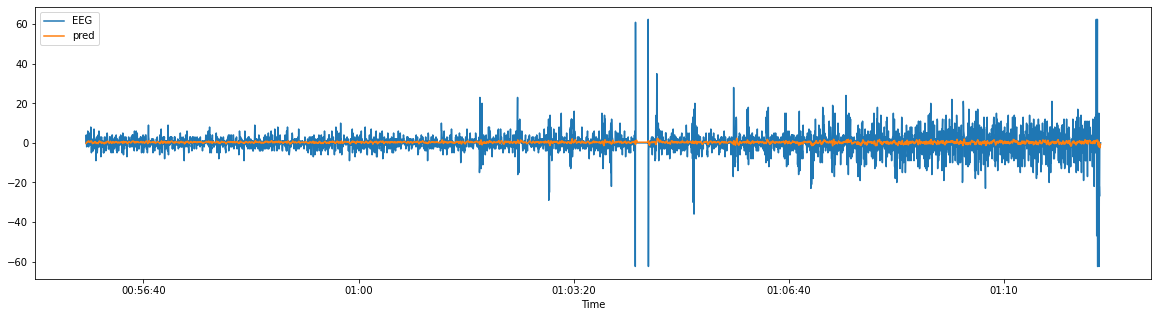

In [101]:
pd.concat([y_test, pd.Series(results, name='pred', index=y_test.index)],axis=1).plot()

In [83]:
print('Prices - OP Results')
print('r2' ,r2_score(results, y_test))
print('mse' ,mean_squared_error(results, y_test))
print('mae', mean_absolute_error(results, y_test))

Prices - OP Results
r2 -223.80991759342766
mse 32.01461839847735
mae 3.2338479941758047


In [84]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(5, 100)
    self.fc3 = nn.Linear(100,1)
    #self.drop1 = nn.Dropout(p=0.5)
    #self.fc2 = nn.Linear(64,32)
    #self.drop2 = nn.Dropout(p=0.5)
  
  def forward(self, X):
    out = torch.tanh(self.fc1(X))
    #out = self.drop1(out)
    #out = torch.relu(self.fc2(out))
    #out = self.drop2(out)
    out = self.fc3(out)
    return out

In [87]:
multi_neuron = MLP()
print(multi_neuron(torch.tensor(X_train.iloc[0]).float()))
print(y_train.iloc[0])

tensor([-0.0343], grad_fn=<AddBackward0>)
EEG    4.99084
Name: 00:00:01, dtype: float64


In [88]:
multi_neuron = MLP()
epochs = 1000
loss_fn = nn.MSELoss()
#optimizer = optim.RMSprop(multi_neuron.parameters(), lr=0.001)
optimizer = optim.SGD(multi_neuron.parameters(), lr=0.01, weight_decay= 0.005)

d:\Users\dav\anaconda3\envs\pos\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Users\dav\anaconda3\envs\pos\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch10, loss 86.81765079250209
Epoch20, loss 86.81078835353836
Epoch30, loss 86.81052069297665
Epoch40, loss 86.81131585640831
Epoch50, loss 86.8131022824783
Epoch60, loss 86.81474345247258
Epoch70, loss 86.8151110703608
Epoch80, loss 86.81502579300098
Epoch90, loss 86.81571564660038
Epoch100, loss 86.81586456483873
Epoch110, loss 86.81480231356629
Epoch120, loss 86.81320168345144
Epoch130, loss 86.81183190591622
Epoch140, loss 86.81076969067482
Epoch150, loss 86.80955572448809
Epoch160, loss 86.80867183073394
Epoch170, loss 86.80810367979298
Epoch180, loss 86.8076268359139
Epoch190, loss 86.80720609981748
Epoch200, loss 86.80700080000622
Epoch210, loss 86.80693060181984
Epoch220, loss 86.80682299692576
Epoch230, loss 86.80663710874936
Epoch240, loss 86.80640712354828
Epoch250, loss 86.80617213742117
Epoch260, loss 86.80595076593343
Epoch270, loss 86.80573262878242
Epoch280, loss 86.80554077551696
Epoch290, loss 86.80540315175415
Epoch300, loss 86.80531096525183
Epoch310, loss 86.8052

<AxesSubplot:>

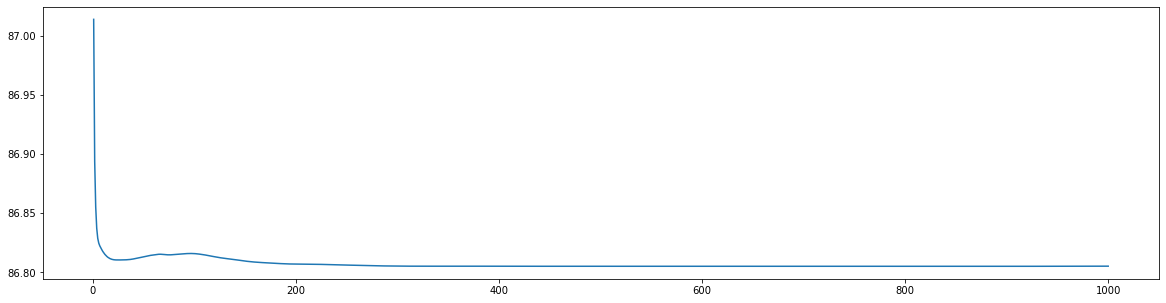

In [90]:
history = {}
for epoch in range(1, epochs+1):
  loss_train = 0.0
  for train_data in train_dataloader:
    x = train_data[:,:5].float()
    y = train_data[:,5].float()
  
    #forward pass
    outputs = multi_neuron(x)

    #loss measure
    loss = loss_fn(outputs,y)

    #backward pass
    optimizer.zero_grad() # pára o autograd
    loss.backward() # executa o backpropagation
    optimizer.step() # atualiza os pesos

    loss_train += loss.item() # soma os erros para obter o erro total

  if (epoch % 10 == 0):
    print('Epoch{}, loss {}'.format(epoch, loss_train / len(train_dataloader))) # apresenta o erro médio da época
  history[epoch] = loss_train / len(train_dataloader)

pd.Series(history).plot()



In [91]:
multi_neuron.eval()
results = []
for test_data in test_dataloader:
    x = test_data[:,:5].float()
    y = test_data[:,5].float()
    
    y_pred = multi_neuron(x)
    results.extend(y_pred.flatten().detach().numpy())
#pd.DataFrame(results).plot()
results[:10]

[-0.30076703,
 -0.28299788,
 0.03447283,
 0.2799933,
 0.2967726,
 0.5274165,
 0.47732288,
 0.34518406,
 0.42814857,
 0.81886053]

<AxesSubplot:xlabel='Time'>

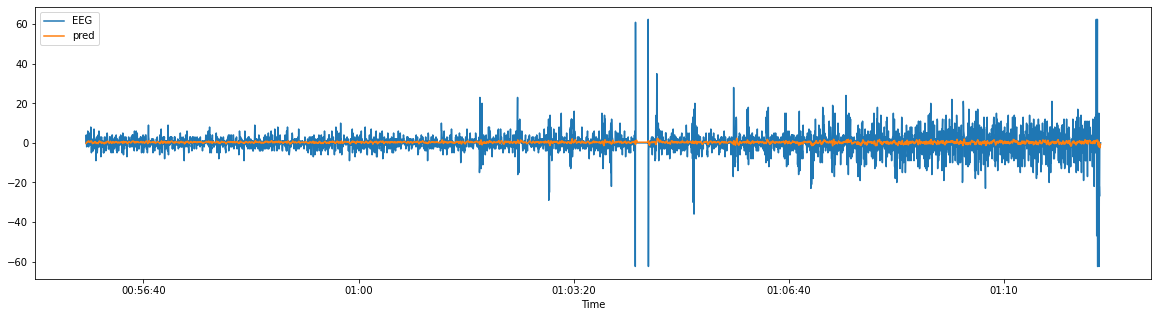

In [102]:
pd.concat([y_test, pd.Series(results, name='pred', index=y_test.index)],axis=1).plot()

In [96]:
print('Prices - MLP Results')
print('r2' ,r2_score(results, y_test))
print('mse' ,mean_squared_error(results, y_test))
print('mae', mean_absolute_error(results, y_test))

Prices - MLP Results
r2 -163.30316440835952
mse 32.021915929347855
mae 3.258952080475984


Redes recorrentes:
* LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
* GRU: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU
